In [1]:
import pandas as pd
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time 

In [2]:

start_time = time.time()
 
engine = create_engine(URL(
                    account = 'account_name',
                    user = 'user_name',
                    password = '12344567',
                    database = 'demo',
                    schema = 'public',
                    warehouse = 'demo_wh'))

with engine.connect() as conn:
    try:
        query = """ select * from OTODOM_DATA_TRANSFORMED """
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
        df = pd.read_sql(query,conn.connection)


        #df = pd.read_csv('/Users/thoufiq/DEV/Python_2023_Cohort1/Project/Dataset/Otodom_Data_ALL.csv')

        print(df.head()) 
        print(df.shape) 

        #df.columns = map(lambda x: str(x).upper(), df.columns)
        
        #df.to_sql('otodom_data_py', con=engine, if_exists='replace', index=False, chunksize=16000, method=pd_writer)
    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))

--- 0.6413741111755371 seconds ---


/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/4121262607.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


   RN ADVERTISER_TYPE BALCONY_GARDEN_TERRACE  \
0  11         private                    Ask   
1  30        business                Balcony   
2  57        business                Balcony   
3  59         private                Balcony   
4  63        business                Balcony   

                                         DESCRIPTION      HEATING IS_FOR_SALE  \
0  Przedstawiamy Państwu ofertę sprzedaży obiektu...          Ask        TRUE   
1  ZAKĄTEK HARMONIA ul. Płochocińska 101\r\n\r\n!...        urban        TRUE   
2  Przedstawiam Państwu na wynajem atrakcyjne mie...  boiler_room       FALSE   
3  Kraków – os. Mistrzejowice – 63 m²\r\n3-POKOJO...        urban        TRUE   
4  ZAKĄTEK HARMONIA ul. Płochocińska 101\r\n\r\n!...        urban        TRUE   

  LIGHTING                                           LOCATION  \
0      Ask           Longitude: 21.00817 | Latitude: 52.23614   
1      Ask         Longitude: 21.029306 | Latitude: 52.336575   
2      Ask  Longitude: 16.943

/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/2557579254.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


       CITY  AVG_RENT_1R  AVG_RENT_2R  AVG_RENT_3R  AVG_RENT_4R
0  Warszawa      2763.49      4219.87      6924.58     12533.66
1   Wrocław      2428.07      3108.77      4491.62      7160.99
2    Kraków      2394.79      3024.76      4234.96      6514.03
3    Gdańsk      2374.17      2930.99      4452.33      6170.89
4  Katowice      1716.44      2335.50      3156.23      5494.10
--- FINAL --- 11.468554019927979 seconds ---


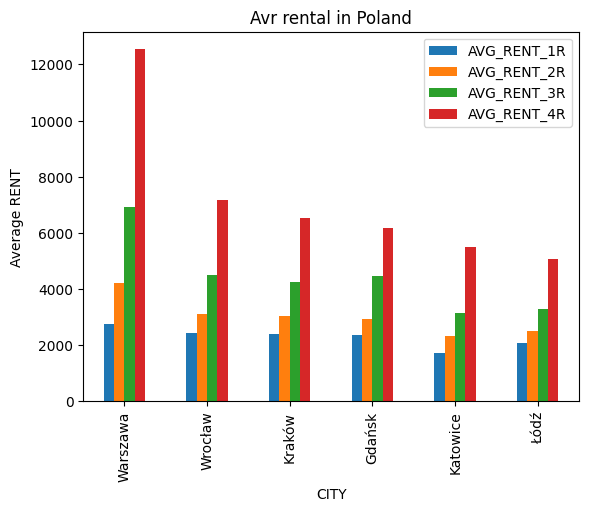

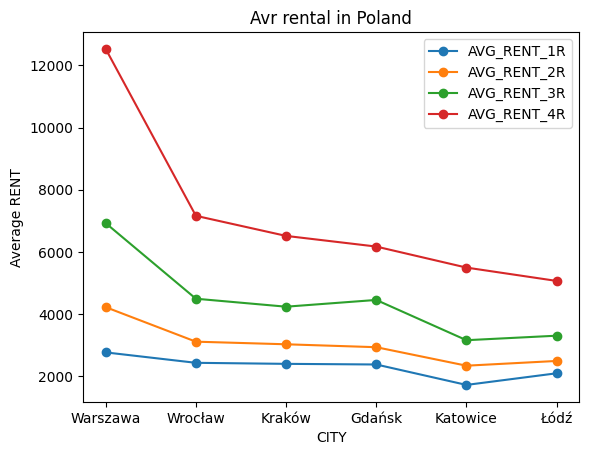

In [3]:
with engine.connect() as conn:
    try:
        query = """ select city, round(avg_rent_1R,2) as avg_rent_1R
                    , round(avg_rent_2R,2) as avg_rent_2R, round(avg_rent_3R,2) as avg_rent_3R
                    , round(avg_rent_4R,2) as avg_rent_4R
                    from (
                        select city,no_of_rooms,price_new
                        from OTODOM_DATA_TRANSFORMED
                        where city in ('Warszawa', 'Wrocław', 'Kraków', 'Gdańsk', 'Katowice', 'Łódź')
                        and apartment_flag = 'apartment'
                        and lower(is_for_sale)='false' 
                        and no_of_rooms in (1,2,3,4)) x
                    pivot 
                        (
                            avg(price_new)
                            for no_of_rooms in ('1','2','3','4')
                        ) 
                        as p(city,avg_rent_1R, avg_rent_2R, avg_rent_3R, avg_rent_4R)
                    order by avg_rent_4R desc  """
        
        df = pd.read_sql(query,conn.connection)
        print(df.head())

        
        df.plot.bar(x="CITY", y=["AVG_RENT_1R","AVG_RENT_2R","AVG_RENT_3R","AVG_RENT_4R"]
                      ,  title="Avr rental in Poland", xlabel='CITY', ylabel='Average RENT');


        df.plot(x="CITY", y=["AVG_RENT_1R","AVG_RENT_2R","AVG_RENT_3R","AVG_RENT_4R"]
                      ,  title="Avr rental in Poland", xlabel='CITY', ylabel='Average RENT'
                      , marker='o');

        #plot.show();

    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))

/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/1757285222.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


           SUBURB  NO_OF_APARTMENTS
0       Białołęka                23
1           Wawer                16
2  Praga-Południe                10
3          Włochy                 7
4        Targówek                 6
--- FINAL --- 12.353811979293823 seconds ---


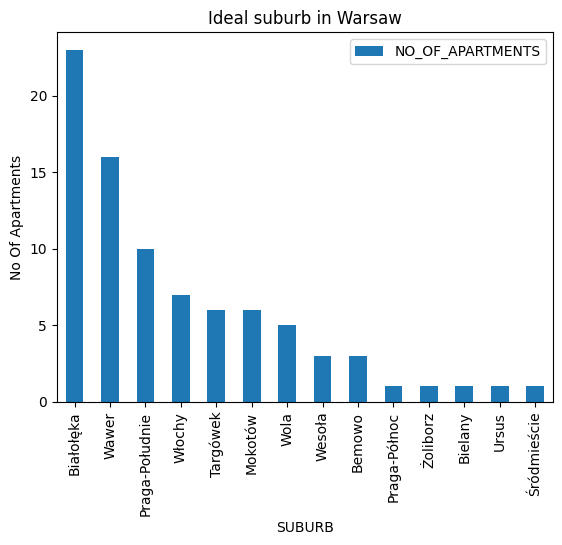

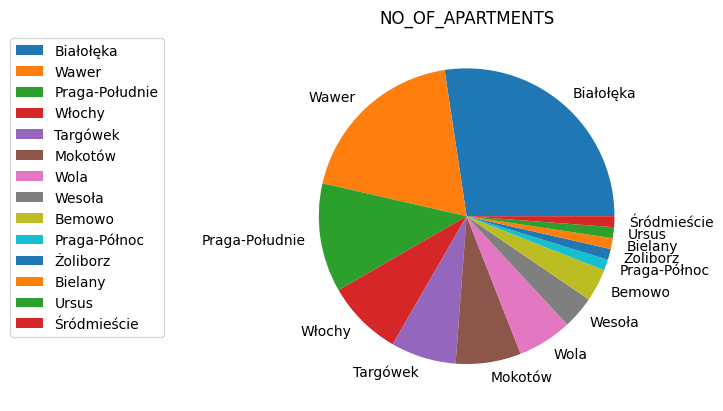

In [4]:
with engine.connect() as conn:
    try:
        query = """ select suburb, count(1) as no_of_apartments
                	from otodom_data_transformed
                	where city in ('Warszawa')
                	and apartment_flag = 'apartment'
                	and lower(is_for_sale) = 'true'
                	and surface_new between 90 and 100
                	and price_new between 800000 and 1000000
                	group by suburb
                	order by count(1)  desc;  """
        
        df = pd.read_sql(query,conn.connection)
        print(df.head())

        
        df.plot.bar(x="SUBURB", y="NO_OF_APARTMENTS"
                      ,  title="Ideal suburb in Warsaw", xlabel='SUBURB', ylabel='No Of Apartments');

        lbl = df["SUBURB"]
        p1 = df.plot.pie(y="NO_OF_APARTMENTS",labels=lbl)
        p1.legend(bbox_to_anchor=(-0.3, 1.0))
        p1.set_title("NO_OF_APARTMENTS")
        p1.axis("off")

        #plot.show();

    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))

/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/3790149319.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


       CITY  AVG_RENTAL    AVG_SALE
0  Warszawa     7390.94  1131123.47
1   Wrocław     4846.29   724785.55
2    Kraków     4678.34   826511.42
3    Gdańsk     4269.67   816461.71
4  Katowice     3925.69   560819.51
--- FINAL --- 13.147073984146118 seconds ---


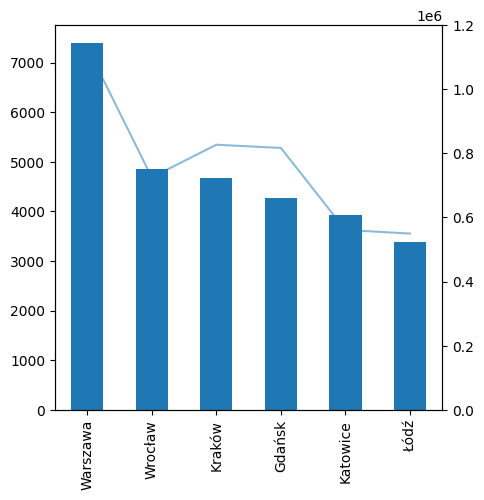

In [5]:
with engine.connect() as conn:
    try:
        query = """ with cte as
                	(select city
                	, (case when lower(is_for_sale)='false' then round(avg(price_new),2) end) as avg_rental
                	, (case when lower(is_for_sale)='true'  then round(avg(price_new),2) end) as avg_sale
                	from otodom_data_transformed
                	where city in ('Warszawa', 'Wrocław', 'Kraków', 'Gdańsk', 'Katowice', 'Łódź')
                	and apartment_flag = 'apartment'
                	group by city, is_for_sale)
                	select city, max(avg_rental) as avg_rental, max(avg_sale) as avg_sale
                	from cte
                	group by city
                	order by avg_rental desc ;	 """
        
        df = pd.read_sql(query,conn.connection)
        print(df.head())

        fig, ax1 = plt.subplots(figsize = (5, 5))
        ax2 = plt.twinx(ax = ax1)
        df['AVG_RENTAL'].plot(kind = 'bar', stacked = True, ax = ax1)
        df['AVG_SALE'].plot(ax = ax2, alpha = 0.5)
        ax2.set_ylim(0, 1200000)
        ax1.set_xticklabels(df['CITY'])
                
    
        
        # df.plot(x="CITY", y=["AVG_RENTAL","AVG_SALE"]
        #               ,  title="Ideal suburb in Warsaw", xlabel='SUBURB', ylabel='No Of Apartments');

        # lbl = df["SUBURB"]
        # p1 = df.plot.pie(y="NO_OF_APARTMENTS",labels=lbl)
        # p1.legend(bbox_to_anchor=(-0.3, 1.0))
        # p1.set_title("NO_OF_APARTMENTS1")
        # p1.axis("off")

        #plot.show();

    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))

/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/4086495706.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


       CITY   AVG_AREA
0  Warszawa  49.284041
1   Wrocław  53.717078
2    Kraków  54.088478
3    Gdańsk  54.982038
4  Katowice  71.367596
--- FINAL --- 13.804893970489502 seconds ---


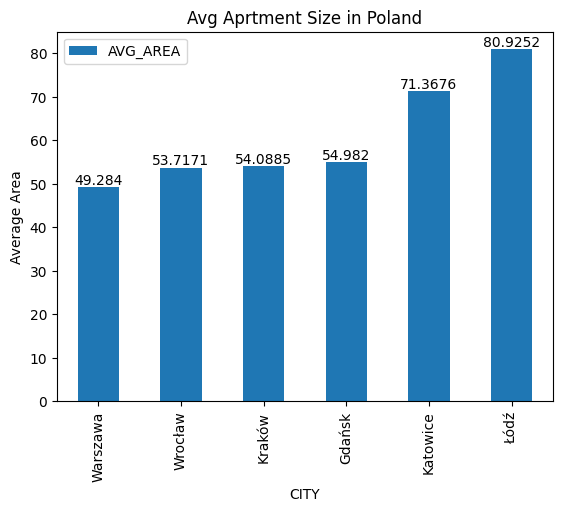

In [6]:
with engine.connect() as conn:
    try:
        query = """ select city, avg(surface_new) avg_area
                	from otodom_data_transformed
                	where city in ('Warszawa', 'Wrocław', 'Kraków', 'Gdańsk', 'Katowice', 'Łódź')
                	and apartment_flag = 'apartment'
                	and lower(is_for_sale) = 'false'
                	and price_new between 3000 and 4000
                	group by city
                	order by avg_area;	 """
        
        df = pd.read_sql(query,conn.connection)
        print(df.head())

        
        ax = df.plot.bar(x="CITY", y="AVG_AREA"
                      ,  title="Avg Aprtment Size in Poland", xlabel='CITY', ylabel='Average Area');
        ax.bar_label(ax.containers[0])


    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))

/var/folders/kf/85m6swz9055f514gqzp20lnh0000gn/T/ipykernel_92299/1594517401.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn.connection)


    FLAG  NUM_APARTMENT
0   0~1k            113
1  1k~2k            140
2  2k~3k            879
3  3k~4k           1050
4  4k~5k            547
--- FINAL --- 14.511287927627563 seconds ---


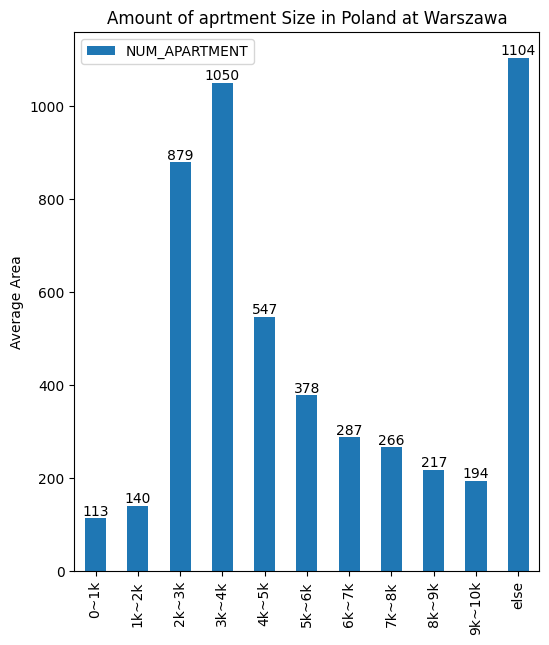

In [7]:
with engine.connect() as conn:
    try:
        query = """ with cte as (
                    select city, price_new
                    ,case when price_new between 0 and 1000 then '0~1k'
                          when price_new between 1000 and 2000 then '1k~2k'
                          when price_new between 2000 and 3000 then '2k~3k'
                          when price_new between 3000 and 4000 then '3k~4k'
                          when price_new between 4000 and 5000 then '4k~5k'
                          when price_new between 5000 and 6000 then '5k~6k'
                          when price_new between 6000 and 7000 then '6k~7k'
                          when price_new between 7000 and 8000 then '7k~8k'
                          when price_new between 8000 and 9000 then '8k~9k'
                          when price_new between 9000 and 10000 then '9k~10k'
                          else 'else'
                          end as flag
                    from otodom_data_transformed
                    where city = 'Warszawa' 
                    and apartment_flag = 'apartment'
                    and lower(is_for_sale) = 'false'
                    )
                    select Flag, count(1) as Num_Apartment
                    from cte
                    group by 1
                    order by 1 """
        
        df = pd.read_sql(query,conn.connection)
        print(df.head())

        
        ax = df.plot.bar(x="FLAG", y=["NUM_APARTMENT"]
                      ,  title="Amount of aprtment Size in Poland at Warszawa", xlabel='',ylabel='Average Area', figsize = (6,7));
        ax.bar_label(ax.containers[0])

    except Exception as e:
        print('--- Error --- ',e)
    finally:
        conn.close()
engine.dispose()

print("--- FINAL --- %s seconds ---" % (time.time() - start_time))